# Homework 4: Parallel processing


### Jacob J. Bukoski, collaborating with Zhongqi Miao & Oliver Muellerklein



In [2]:
# Set the number of darts to be thrown here. All means of parallel processing use this same variable
# for comparability

number_of_darts = 10000000
cores = 4

In [3]:
# Build out all necessary functions:
from time import time
from multiprocessing import Pool
import ipyparallel as ipp

# ipcluster start -n 4   <-- Run this in bash

# Start the ipp client
c = ipp.Client()

# Define dart throwing function that will be called

def throw_darts(number_of_darts, cores):
    from random import uniform
    from math import sqrt
    hit = 0
    for i in range(int(number_of_darts/cores)):
        x, y = uniform(0,1), uniform(0,1)
        if sqrt((x-0.5)**2 + (y-0.5)**2) <= 0.5:
            hit += 1       
    return hit

def ser(number_of_darts, cores):
    start_time = time()
    darts_in_circ = throw_darts(number_of_darts, cores=1)
    end_time = time()
    
    pi_approx = 4 * darts_in_circ / float(number_of_darts)
    execution_time = end_time - start_time
    throw_rate = int(number_of_darts/execution_time)
    
    return(execution_time, throw_rate, darts_in_circ, pi_approx)
    

def multproc(number_of_darts, cores):
    start_time = time()
    results = []

    def collect_results(result):
        results.append(result)

    p = Pool(cores)
    
    for i in range(cores):
        p.apply_async(throw_darts, (number_of_darts, cores), callback = collect_results)
    p.close()
    p.join()
    
    sum_darts_in_circ = sum(results)

    end_time = time()  

    pi_approx = 4 * sum_darts_in_circ / float(number_of_darts) 
    execution_time = end_time - start_time
    throw_rate = int(number_of_darts/execution_time)
    
    return(execution_time, throw_rate, sum_darts_in_circ, pi_approx)

def ipp(number_of_darts, cores):
    start_time = time()

    result = None
    result = c[:].apply_async(throw_darts, number_of_darts, cores)
    sum_darts_in_circ = sum(result.get())

    end_time = time()  

    pi_approx = 4 * sum_darts_in_circ / float(number_of_darts) 
    execution_time = end_time - start_time
    throw_rate = int(number_of_darts/execution_time)
    
    return(execution_time, throw_rate, sum_darts_in_circ, pi_approx)


In [4]:
# Test the simulations

test_ser = ser(number_of_darts/2, cores)
test_mp = multproc(number_of_darts/2, cores)
test_ipp = ipp(number_of_darts/2, cores)

print("test_ser:", test_ser)
print("test_mp:", test_mp)
print("test_ipp:", test_ipp)


test_ser: (5.190502166748047, 963297, 3927649, 3.1421192)
test_mp: (2.8226981163024902, 1771354, 3926985, 3.141588)
test_ipp: (2.8479576110839844, 1755644, 3926239, 3.1409912)


In [5]:
# Build the data for the plot

import pandas as pd
import numpy as np

data = []

vals = np.logspace(1,8,30, dtype='int64')

for i in vals:
    data.append([ser(i, cores), multproc(i, cores), ipp(i, cores)])

dat_array = np.array(data)

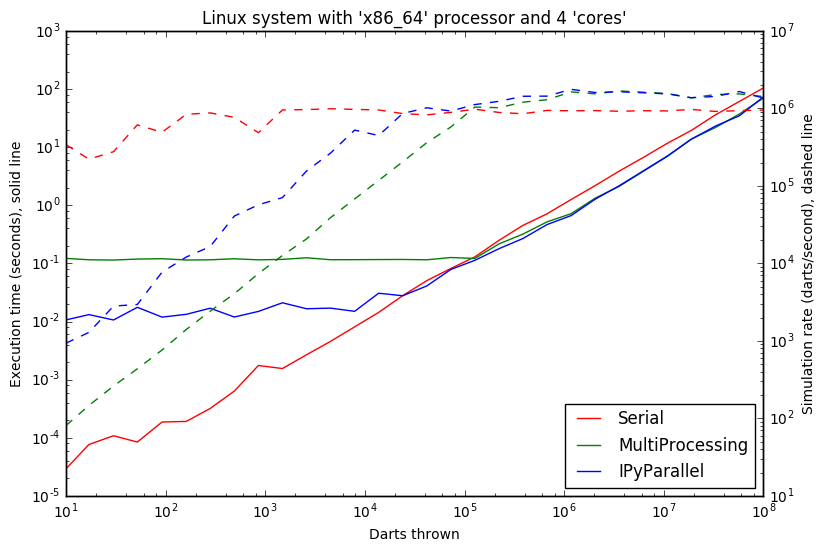

In [6]:
# Code to generate the plot and compare the different parallelization techniques against one another
import platform
from numpy import arange
import matplotlib.pyplot as plt
from multiprocessing import cpu_count

darts = vals

fig, ax1 = plt.subplots(figsize = (9,6))
ax1.plot(darts, dat_array[:,0][:,0], 'r', label = 'Serial')
ax1.plot(darts, dat_array[:,1][:,0], 'g', label = 'MultiProcessing')
ax1.plot(darts, dat_array[:,2][:,0], 'b', label = 'IPyParallel')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Darts thrown')
ax1.set_ylabel('Execution time (seconds), solid line')

ax2 = ax1.twinx()
ax2.plot(darts, dat_array[:,0][:,1], 'r--')
ax2.plot(darts, dat_array[:,1][:,1], 'g--')
ax2.plot(darts, dat_array[:,2][:,1], 'b--')
ax2.set_yscale('log')
ax2.set_ylabel('Simulation rate (darts/second), dashed line')
ax2.set_title("%s system with '%s' processor and %s 'cores'" %(platform.system(), platform.processor(), cpu_count()))

ax1.legend(loc=4)

plt.show()
